# OpenCV DNN을 이용하여 SSD 기반 객체 탐지 수행
* 텐서플로에서 사전 훈련된 모델 파일을 OpenCV에서 로드하여 이미지와 영상에 대한 객체 탐지 수행
* SSD+Inception과 SSD+MobileNet v3를 모두 테스트 

## 이미지와 사전 훈련 모델 다운로드


In [20]:
# 디렉터리 생성
!mkdir /content/data
# 이미지 다운로드
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

mkdir: cannot create directory ‘/content/data’: File exists
--2022-04-10 13:59:48--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.03s   

2022-04-10 13:59:48 (10.9 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



In [21]:
!mkdir ./pretrained

# 사전 훈련 모델 다운로드
!wget -O ./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz 
# 모델 config 파일 다운로드
!wget -O ./pretrained/ssd_config_01.pbtxt  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt

# 사전 훈련 모델 압축 풀기
!tar -xvf ./pretrained/ssd_inception*.tar.gz -C ./pretrained 

mkdir: cannot create directory ‘./pretrained’: File exists
--2022-04-10 13:59:49--  http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.148.128, 2607:f8b0:4001:c54::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.148.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278126337 (265M) [application/x-tar]
Saving to: ‘./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz’

./pretrained/ssd_in 100%[===================>] 265.24M   228MB/s    in 1.2s    

2022-04-10 13:59:50 (228 MB/s) - ‘./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz’ saved [278126337/278126337]

--2022-04-10 13:59:50--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Con

## 모델 생성

In [22]:
import cv2

pretrained_model_weight = '/content/pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb'
model_config = '/content/pretrained/ssd_config_01.pbtxt'

# inference 모델 생성
cv_net = cv2.dnn.readNetFromTensorflow(pretrained_model_weight, model_config)

In [23]:
# COCO 데이터셋의 클래스 ID별 클래스명을 매칭한 딕셔너리 생성
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

## 객체 탐지 수행

### 이미지 활용 객체 탐지

In [24]:
import matplotlib.pyplot as plt

def get_detected_img(cv_net, img_array, score_threshold):
    # 원본 이미지의 형상 정보 ---①
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    img_copy = img_array.copy() # 원본 이미지 복사본 ---②
    
    # 이미지 크기를 (300, 300)으로, BGR을 RGB로 변환해 네트워크에 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_copy, size=(300, 300), swapRB=True, crop=False))
    
    # 객체 탐지 수행 ---③
    cv_outs = cv_net.forward()
    
    green_color = (0, 255, 0) # 경계 박스 테두리 색상
    red_color = (0, 0, 255)   # 텍스트 색상

    # 탐지된 객체들을 순회하면서 정보 추출
    for cv_out in cv_outs[0,0,:,:]:
        class_id = int(cv_out[1]) # 객체 클래스 ID
        confidence_score = float(cv_out[2])  # 신뢰도 점수

        # 신뢰도 점수가 score_threshold보다 큰 객체만 추출
        if confidence_score > score_threshold:
            # 원본 이미지 크기로 원복 ---④
            x_min = cv_out[3] * cols
            y_min = cv_out[4] * rows
            x_max = cv_out[5] * cols
            y_max = cv_out[6] * rows

            class_name = labels_to_names[class_id] # 클래스명 ---⑤
            caption = f'{class_name}: {confidence_score:.4f}'

            # 경계 박스와 캡션(클래스명, 신뢰도 점수) 표시(위치 인자는 반드시 정수형)
            cv2.rectangle(img_copy, (int(x_min), int(y_min)), (int(x_max), int(y_max)), 
                          color=green_color, thickness=2)
            cv2.putText(img_copy, caption, (int(x_min), int(y_min - 5)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)

    return img_copy

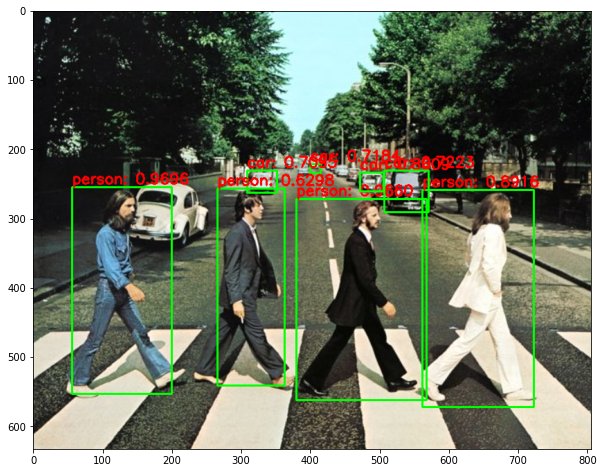

In [25]:
img = cv2.imread('/content/data/beatles01.jpg')

# 객체 탐지 수행
detected_img = get_detected_img(cv_net, img, score_threshold=0.6)

detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(detected_img);

--2022-04-10 13:59:56--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76279 (74K) [image/jpeg]
Saving to: ‘./data/baseball01.jpg’

./data/baseball01.j 100%[===================>]  74.49K  --.-KB/s    in 0.01s   

2022-04-10 13:59:56 (6.13 MB/s) - ‘./data/baseball01.jpg’ saved [76279/76279]



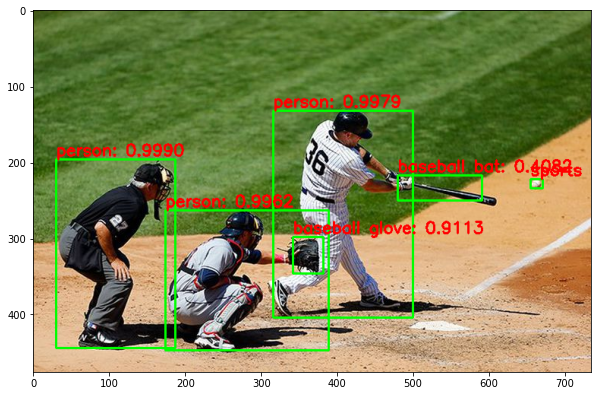

In [26]:
# 이미지 다운로드
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

img = cv2.imread('/content/data/baseball01.jpg')

# 객체 탐지 수행
detected_img = get_detected_img(cv_net, img, score_threshold=0.4)

detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(detected_img);

### 영상 활용 객체 탐지

In [27]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2022-04-10 13:59:57--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2022-04-10 13:59:57--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2022-04-10 13:59:57--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.

In [28]:
def write_detected_video(cv_net, input_path, output_path, score_threshold):
    cap = cv2.VideoCapture(input_path) # 비디오 캡쳐 객체 생성

    codec = cv2.VideoWriter_fourcc(*'XVID') # Codec은 *'XVID'로 설정

    video_fps = cap.get(cv2.CAP_PROP_FPS)                  # FPS(Frames Per Second)
    video_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)        # 비디오 캡쳐 객체 프레임의 너비
    video_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)      # 비디오 캡쳐 객체 프레임의 높이
    video_size = (round(video_width), round(video_height)) # 비디오 크기 
    # VideoWriter 객체 생성
    video_writer = cv2.VideoWriter(output_path, codec, video_fps, video_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # Frame 개수
    print('총 Frame 개수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read() # 비디오 캡쳐 객체에서 Frame 하나 읽기 
        if not hasFrame: # 처리할 Frame이 없으면 중단
            break
        # 해당 프레임 이미지를 활용해 객체 탐지 inference 수행
        img_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold)
        video_writer.write(img_frame)

    video_writer.release() # video_writer 닫기
    cap.release() # cap 닫기

In [29]:
write_detected_video(cv_net, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_detected.mp4', 0.3)

총 Frame 개수: 58


## Mobilenet v3 기반의 SSD로 객체 탐지 수행

In [30]:
!mkdir ./pretrained

!wget -O ./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz
!wget -O ./pretrained/ssd_config_02.pbtxt https://gist.githubusercontent.com/dkurt/54a8e8b51beb3bd3f770b79e56927bd7/raw/2a20064a9d33b893dd95d2567da126d0ecd03e85/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt

!!tar -xvf ./pretrained/ssd_mobilenet*.tar.gz -C ./pretrained 

mkdir: cannot create directory ‘./pretrained’: File exists
--2022-04-10 14:00:12--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.148.128, 2607:f8b0:4001:c54::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.148.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49318766 (47M) [application/gzip]
Saving to: ‘./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz’

./pretrained/ssd_mo 100%[===================>]  47.03M   241MB/s    in 0.2s    

2022-04-10 14:00:12 (241 MB/s) - ‘./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz’ saved [49318766/49318766]

--2022-04-10 14:00:12--  https://gist.githubusercontent.com/dkurt/54a8e8b51beb3bd3f770b79e56927bd7/raw/2a20064a9d33b893dd95d2567da126d0ecd03e85/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt
Resolving gist.githubusercontent.com (gist.githubusercontent.

['ssd_mobilenet_v3_large_coco_2020_01_14/pipeline.config',
 'ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt.index',
 'ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt.data-00000-of-00001',
 'ssd_mobilenet_v3_large_coco_2020_01_14/model.tflite',
 'ssd_mobilenet_v3_large_coco_2020_01_14/frozen_inference_graph.pb',
 'ssd_mobilenet_v3_large_coco_2020_01_14/checkpoint',
 'ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt.meta',
 'ssd_mobilenet_v3_large_coco_2020_01_14/']

In [31]:
# OpenCV 버전 업그레이드
!pip install opencv-python==4.5.2.54

In [32]:
import cv2

pretrained_model_weight = '/content/pretrained/ssd_mobilenet_v3_large_coco_2020_01_14/frozen_inference_graph.pb'
model_config = '/content/pretrained/ssd_config_02.pbtxt'

# 모델 생성
cv_net = cv2.dnn_DetectionModel(pretrained_model_weight, model_config)

# MobileNet v3 기반 SSD 모델은 이미지 픽셀값을 -1~1 사이로 정규화하고, 이미지 크기는 (320, 320)으로 설정
cv_net.setInputSize(320, 320)
cv_net.setInputScale(1.0 / 127.5)
cv_net.setInputMean((127.5, 127.5, 127.5))
cv_net.setInputSwapRB(True);

### 객체 탐지 수행
- detect() 메서드는 입력 이미지를 받아서 특정 신뢰도 임계값을 넘는 객체 탐지 inference 결과를 반환함
- 반환값은 클래스 ID, 신뢰도 점수, 경계 박스 좌표값임
- 경계 박스 좌표값은 x_min, y_min, width, height 형태로 반환

In [41]:
img = cv2.imread('/content/data/beatles01.jpg')
img_copy = img.copy()

classes, confidences, boxes = cv_net.detect(img_copy, confThreshold=0.6)

In [42]:
classes

array([[1],
       [1],
       [1],
       [1],
       [3],
       [3]], dtype=int32)

In [43]:
confidences

array([[0.7795709 ],
       [0.7573837 ],
       [0.75332576],
       [0.71246046],
       [0.6756758 ],
       [0.6396257 ]], dtype=float32)

In [44]:
boxes

array([[ 48, 258, 154, 291],
       [213, 252, 158, 298],
       [386, 266, 167, 300],
       [560, 251, 153, 322],
       [496, 226,  80,  67],
       [451, 227,  28,  21]], dtype=int32)

In [45]:
# COCO 데이터셋의 클래스 ID별 클래스명을 매칭한 딕셔너리 생성
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [ ]:
import matplotlib.pyplot as plt

green_color=(0, 255, 0)
red_color=(0, 0, 255)

for class_id, confidence_score, box in zip(classes.flatten(), confidences.flatten(), boxes):
    if confidence_score > 0.6:
      caption = f'{labels_to_names[class_id]}: {confidence_score:.4f}'
      # 경계 박스 좌표값은 정수형(x_min, y_min, width, height임에 유의) ---①
      cv2.rectangle(img_copy, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), color=green_color, thickness=2)
      cv2.putText(img_copy, caption, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, red_color, 2)

img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_copy);

- 객체 탐지 함수 정의

In [46]:
import matplotlib.pyplot as plt

def get_detected_img_renew(cv_net, img_array, score_threshold):
  img_copy = img_array.copy()
   
  classes, confidences, boxes = cv_net.detect(img_array, confThreshold=0.5)
  
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # 탐지된 객체들을 순회하면서 정보 추출
  for class_id, confidence_score, box in zip(classes.flatten(), confidences.flatten(), boxes):
    if confidence_score > score_threshold: # 신뢰도 점수가 score_threshold보다 큰 객체만 추출
      caption = f'{labels_to_names[class_id]}: {confidence_score:.4f}'
      # 경계 박스 좌표값은 정수형(x_min, y_min, width, height임에 유의)
      cv2.rectangle(img_copy, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), 
                    color=green_color, thickness=2)
      cv2.putText(img_copy, caption, (box[0], box[1]), 
                  cv2.FONT_HERSHEY_SIMPLEX, 0.6, red_color, 2)

  return img_copy

- DNN 모델을 만드는 함수 정의

In [49]:
def get_cv_detection_model(pretrained_path, config_path):
  cv_net = cv2.dnn_DetectionModel(pretrained_path, config_path)
  cv_net.setInputSize(320, 320)
  cv_net.setInputScale(1.0 / 127.5)
  cv_net.setInputMean((127.5, 127.5, 127.5))
  cv_net.setInputSwapRB(True)

  return cv_net

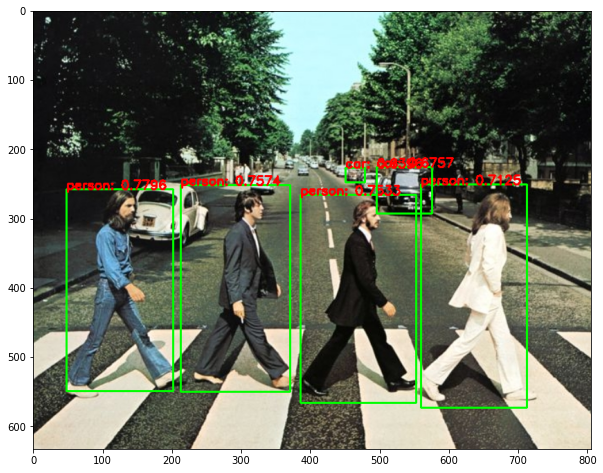

In [51]:
pretrained_model_weight = '/content/pretrained/ssd_mobilenet_v3_large_coco_2020_01_14/frozen_inference_graph.pb'
model_config = '/content/pretrained/ssd_config_02.pbtxt'

# 모델 생성
cv_net = get_cv_detection_model(pretrained_model_weight, model_config)

img = cv2.imread('./data/beatles01.jpg')
img_copy = img.copy()

# 객체 탐지 수행
img_copy = get_detected_img_renew(cv_net, img_copy, score_threshold=0.6)
# BRG을 RGB로 변환
img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

# 시각화
plt.figure(figsize=(10, 10))
plt.imshow(img_copy);

### 영상 활용 객체 탐지

In [52]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2022-04-10 14:23:10--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2022-04-10 14:23:11--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2022-04-10 14:23:11--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.

In [53]:
def write_detected_video(cv_net, input_path, output_path, score_threshold):
    cap = cv2.VideoCapture(input_path) # 비디오 캡쳐 객체 생성

    codec = cv2.VideoWriter_fourcc(*'XVID') # Codec은 *'XVID'로 설정

    video_fps = cap.get(cv2.CAP_PROP_FPS)                  # FPS(Frames Per Second)
    video_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)        # 비디오 캡쳐 객체 프레임의 너비
    video_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)      # 비디오 캡쳐 객체 프레임의 높이
    video_size = (round(video_width), round(video_height)) # 비디오 크기 
    # VideoWriter 객체 생성
    video_writer = cv2.VideoWriter(output_path, codec, video_fps, video_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # Frame 개수
    print('총 Frame 개수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read() # 비디오 캡쳐 객체에서 Frame 하나 읽기 
        if not hasFrame: # 처리할 Frame이 없으면 중단
            break
        # 해당 프레임 이미지를 활용해 객체 탐지 inference 수행
        img_frame = get_detected_img_renew(cv_net, img_frame, score_threshold=score_threshold)
        video_writer.write(img_frame)

    video_writer.release() # video_writer 닫기
    cap.release() # cap 닫기

In [55]:
write_detected_video(cv_net, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_detected2.mp4', 0.3)

총 Frame 개수: 58
